In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF_T256_H05_tl_110data import \
    get_config

In [2]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)
local_bw_rmses = {}
global_bw_rmses = {}

0


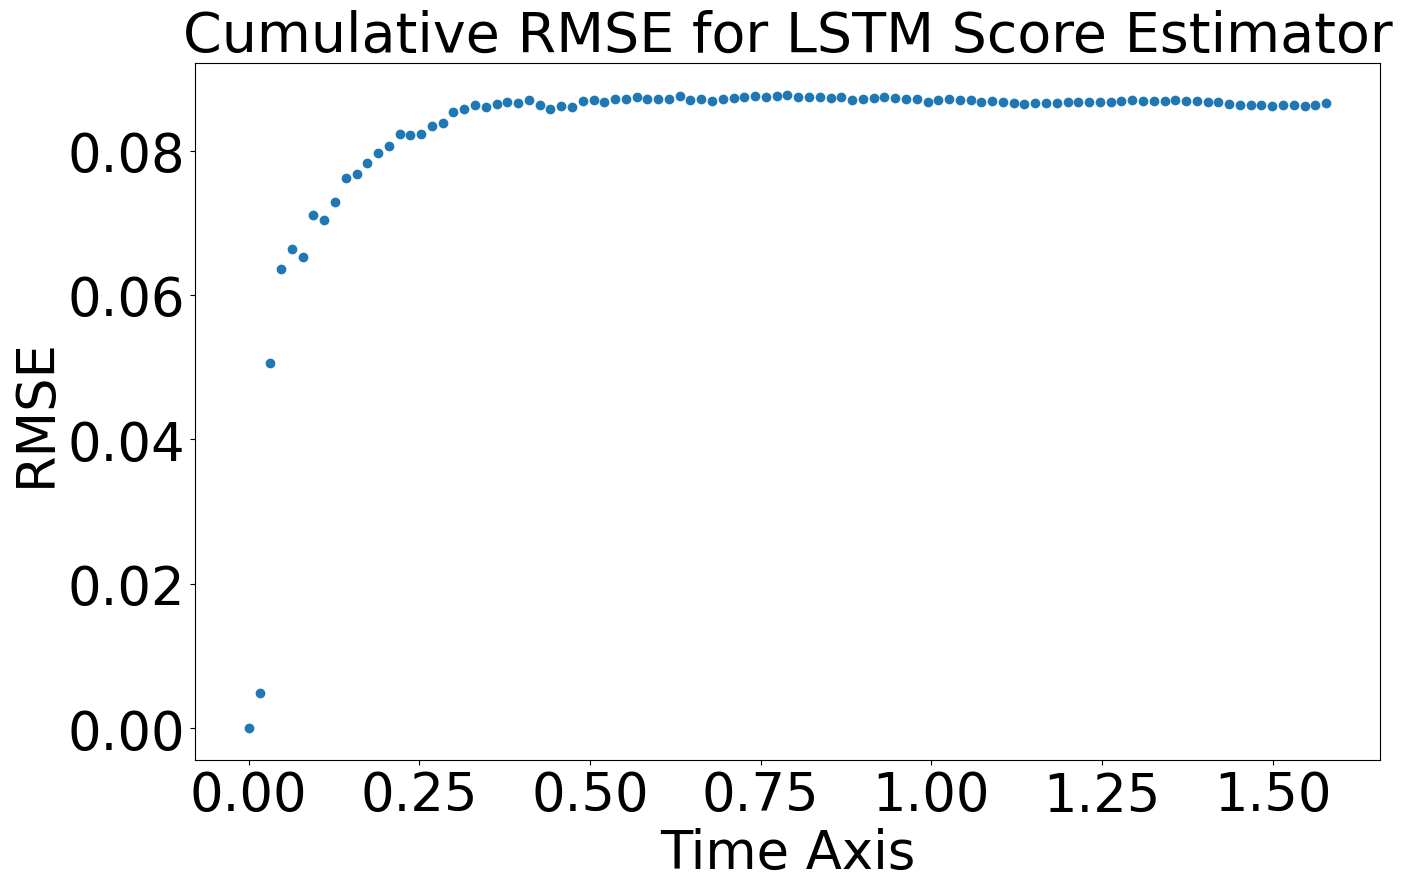

Final time cumulative RMSE local-time error 0.0865696786563898 at Nepoch 150



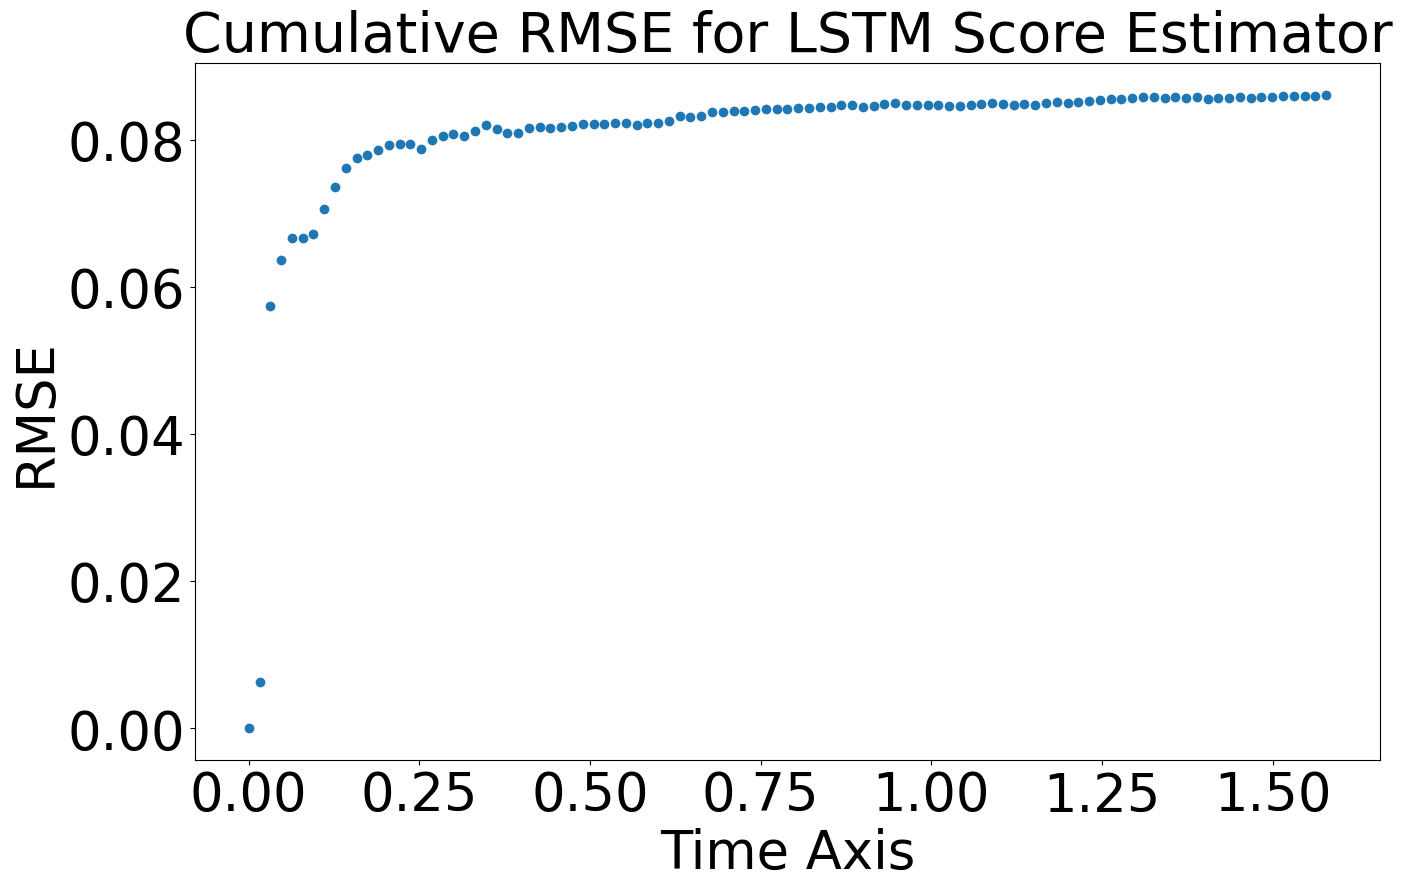

Final time cumulative RMSE local-time error 0.08610777401946332 at Nepoch 960



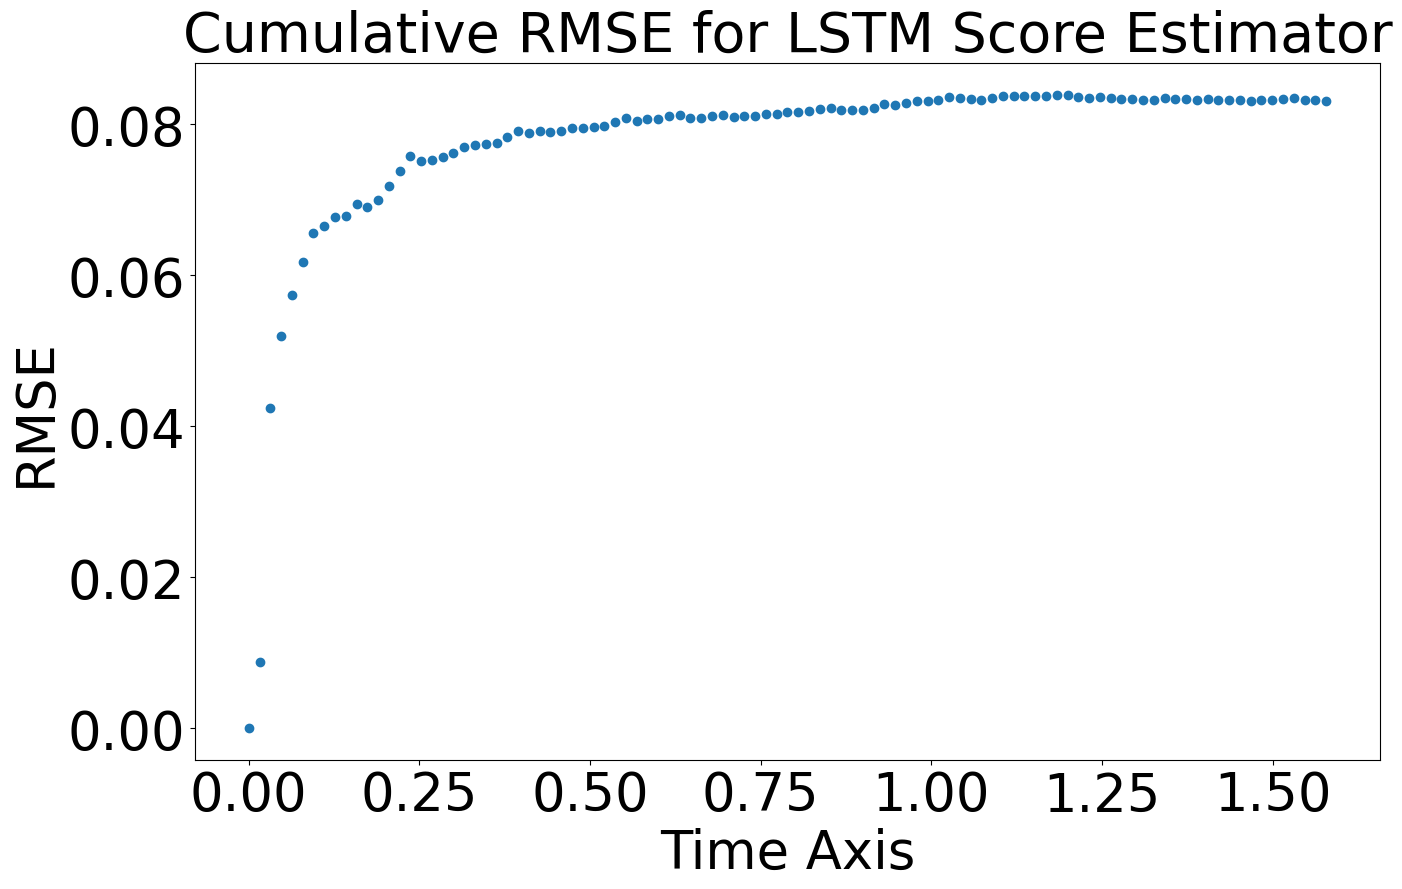

Final time cumulative RMSE local-time error 0.08315232654971631 at Nepoch 1440



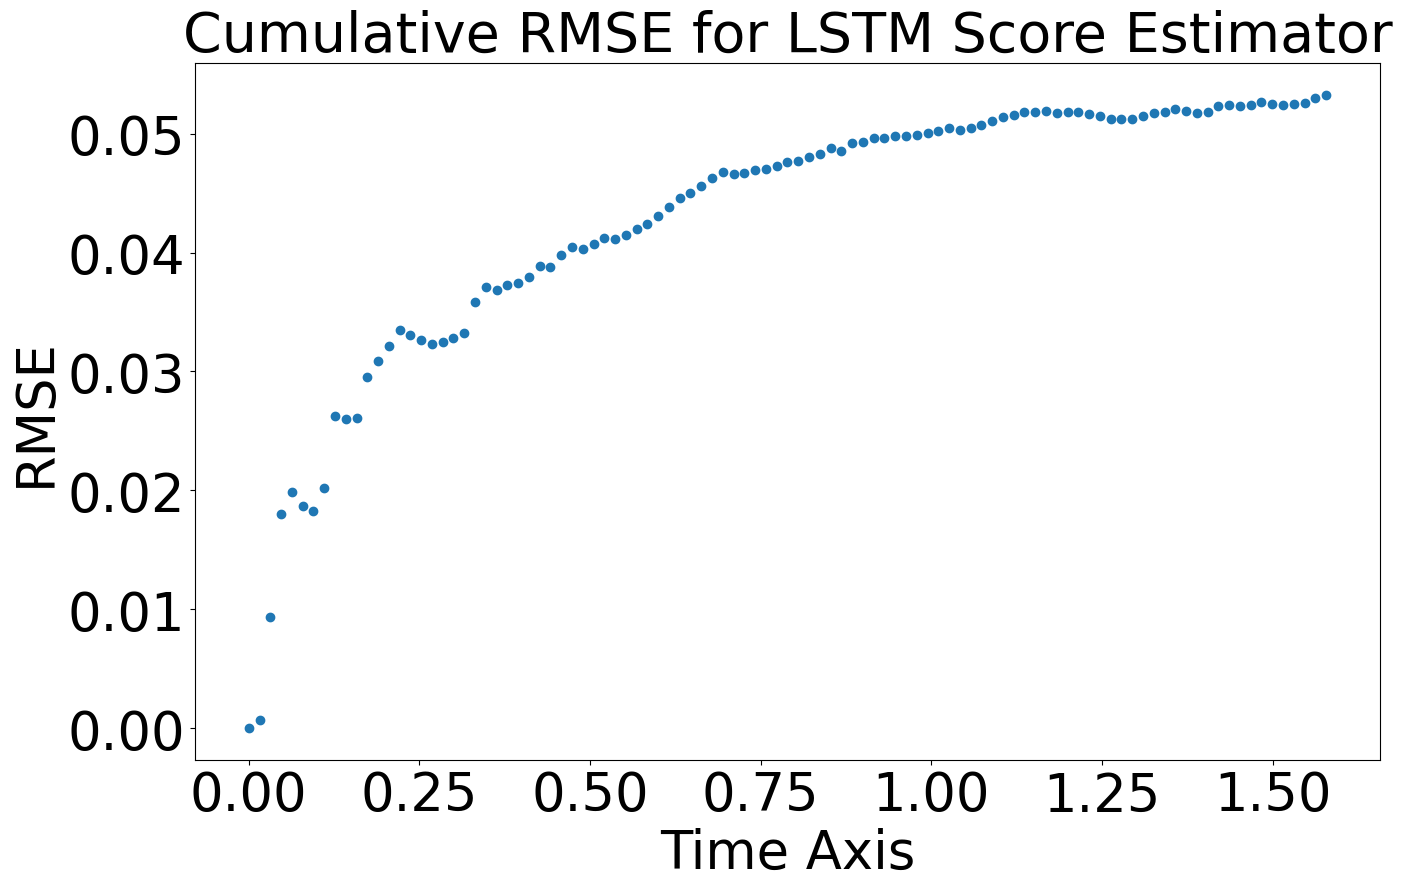

Final time cumulative RMSE local-time error 0.053281098623714135 at Nepoch 2920



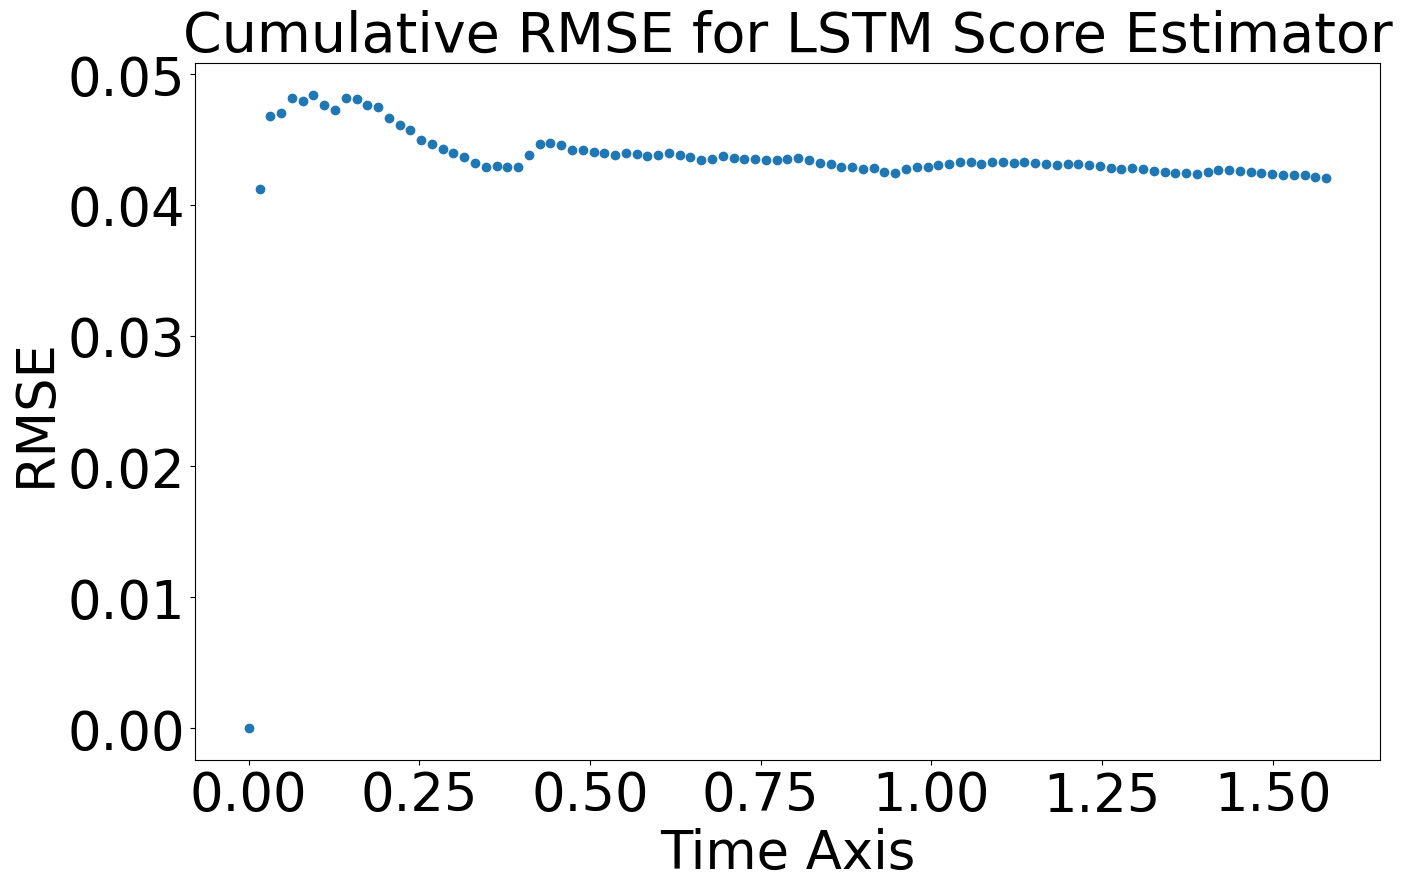

Final time cumulative RMSE local-time error 0.042060177323059604 at Nepoch 6920



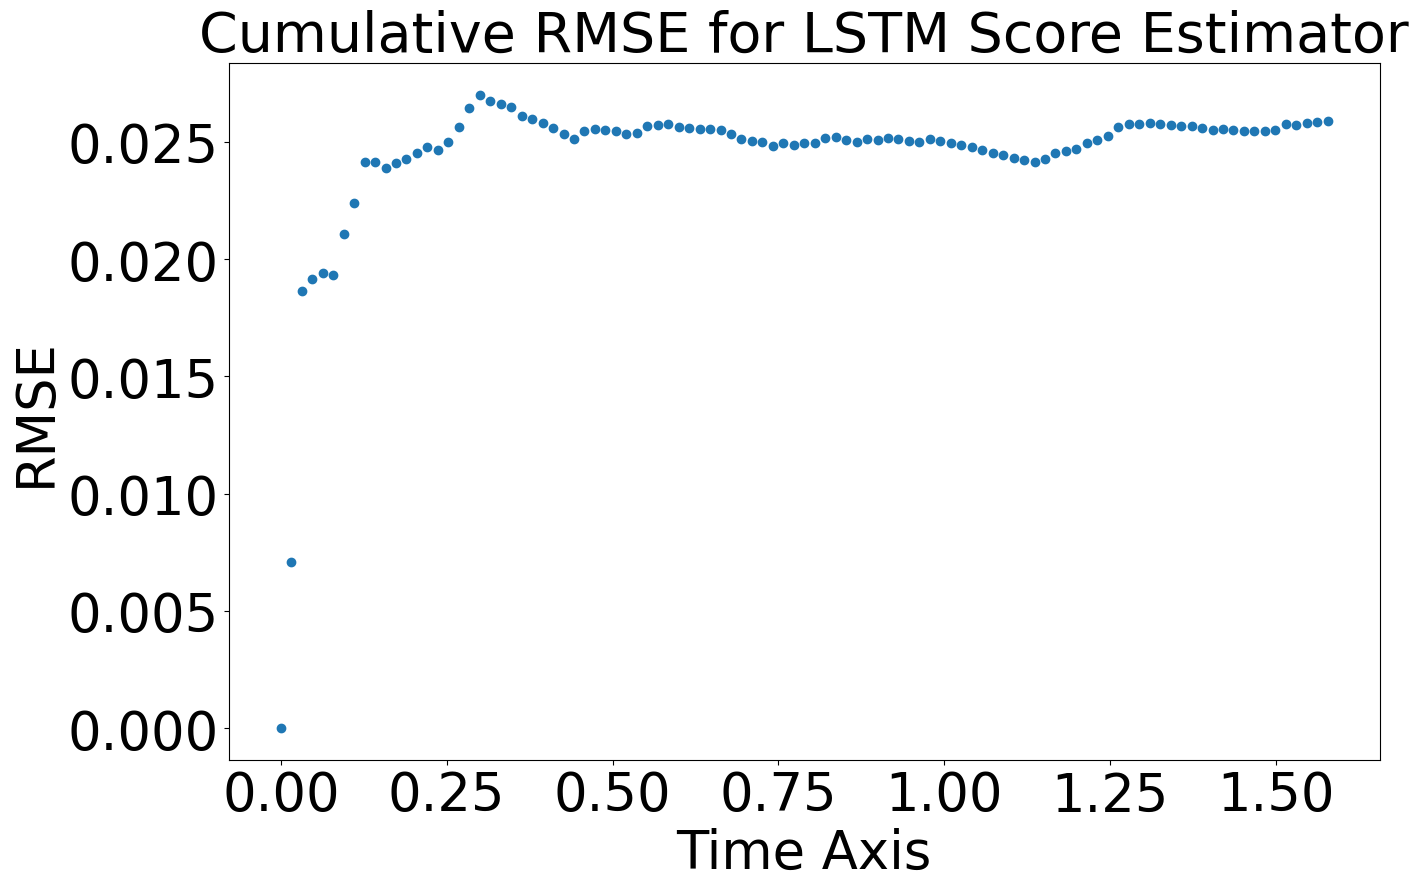

Final time cumulative RMSE local-time error 0.025889254970668043 at Nepoch 7190



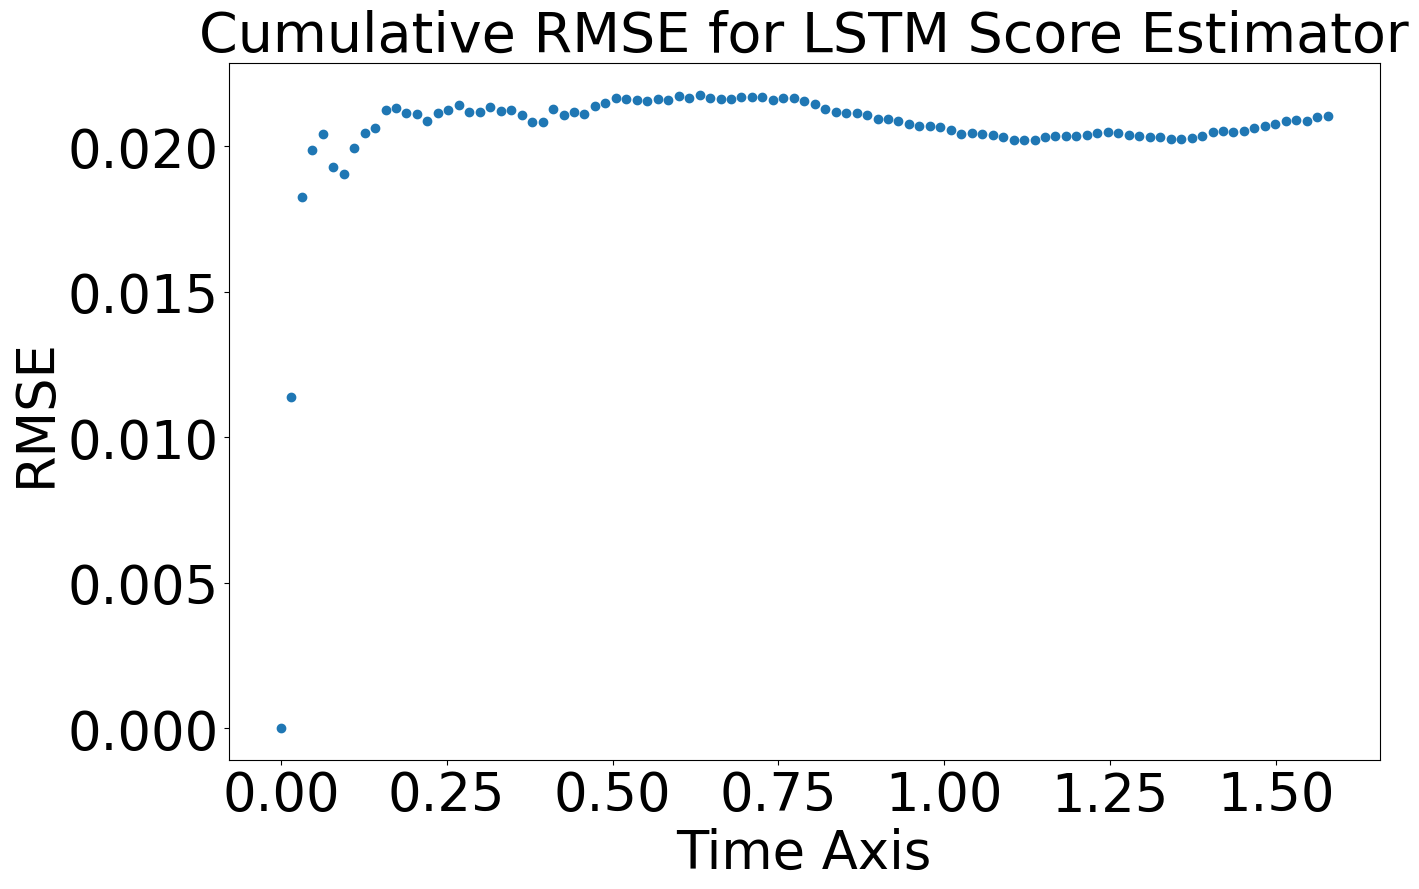

Final time cumulative RMSE local-time error 0.02103922781143702 at Nepoch 8190



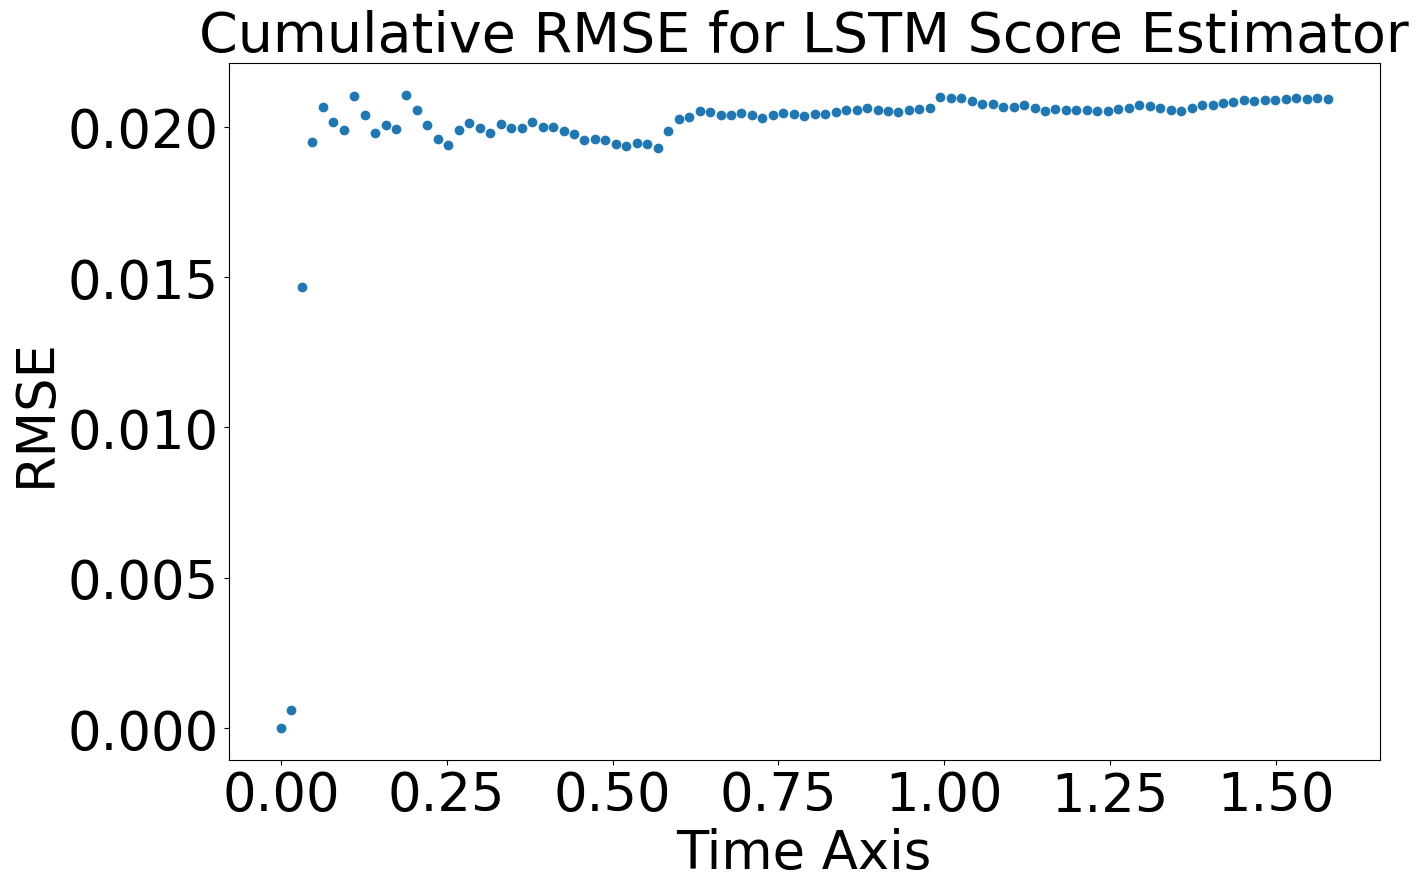

Final time cumulative RMSE local-time error 0.020935243819593722 at Nepoch 9700



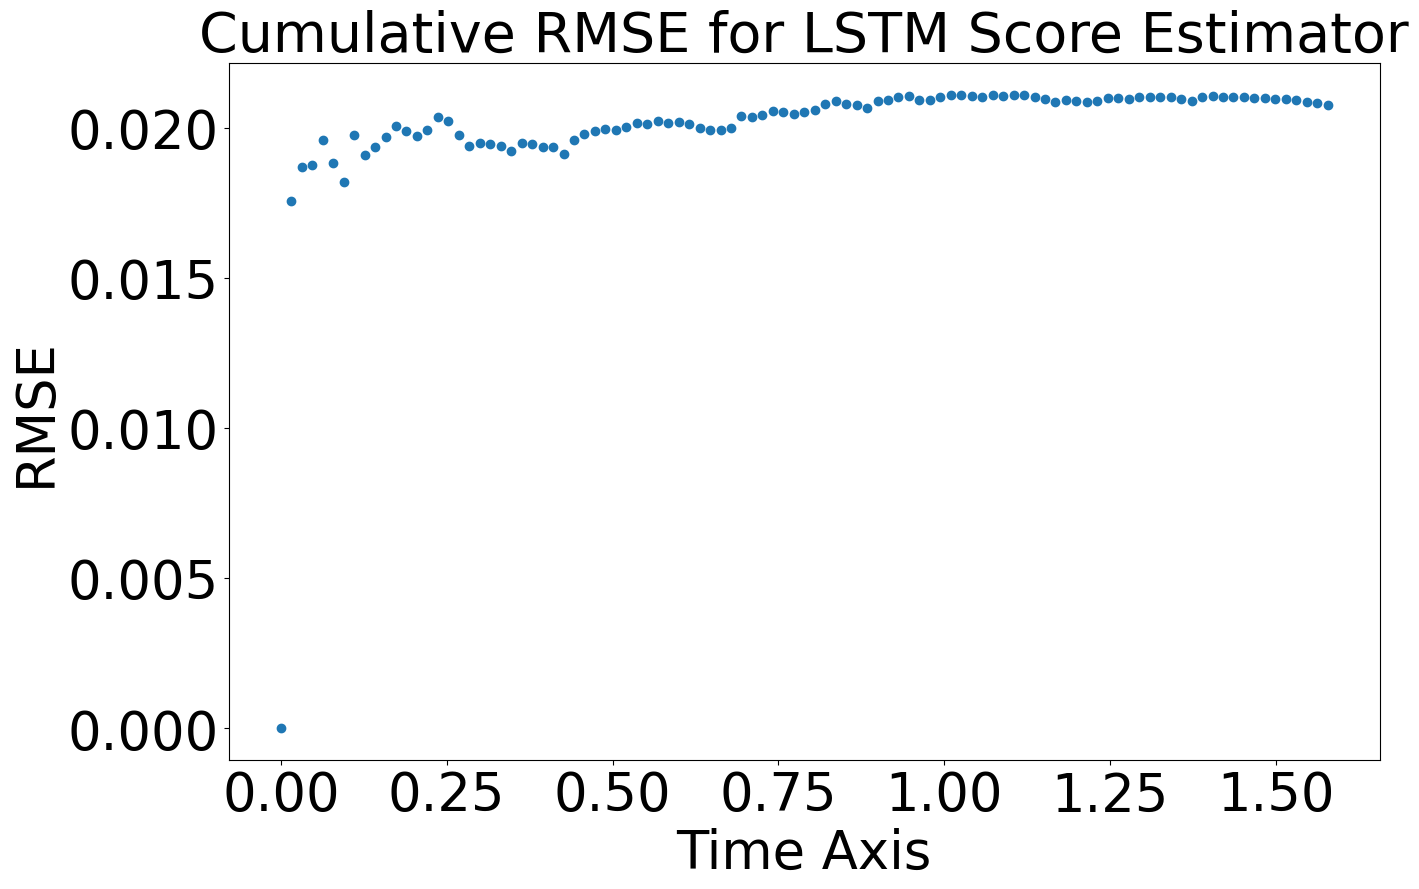

Final time cumulative RMSE local-time error 0.02075175851788203 at Nepoch 12920



In [4]:
curr_rmse = np.inf
for Nepoch in config.max_epochs:
    try:
        if "_ST_" in config.scoreNet_trained_path:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_ST_fQuadSinHF_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")
        else:
            save_path = (
                    project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fQuadSinHF_DriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
                ".", "")

        true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        #global_states= np.load(save_path + "_global_states.npy")/np.sqrt(config.deltaT)
        local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        local_errors = np.power(np.cumsum(np.mean(np.power(true_states- local_states,2), axis=0), axis=0), 0.5) #/np.arange(1, local_states.shape[1]+1)[:, np.newaxis]
        total_local_errors = np.power(np.sum(np.power(local_errors, 2), axis=1)/np.arange(1, local_errors.shape[0]+1), 0.5)
        if total_local_errors[-1] < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError:
        continue